# EDA

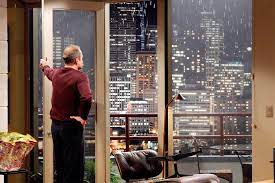

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

__Importing__

We import pandas and the libaries to connect to the database: 

In [2]:
import pandas as pd
import psycopg2

import os
from dotenv import load_dotenv

pd.set_option('display.max_columns', None)

We connect to the database: 

In [3]:
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

In [4]:
# Create connection object conn
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)


We create a cursor: 

In [5]:
cur = conn.cursor()

And we fetch the data query. 

In [6]:
cur.execute('SELECT * FROM eda.king_county_house_sales sales')
cur.fetchall()


[(datetime.date(2014, 10, 13), 221900.0, 7129300520, 1),
 (datetime.date(2014, 12, 9), 538000.0, 6414100192, 2),
 (datetime.date(2015, 2, 25), 180000.0, 5631500400, 3),
 (datetime.date(2014, 12, 9), 604000.0, 2487200875, 4),
 (datetime.date(2015, 2, 18), 510000.0, 1954400510, 5),
 (datetime.date(2014, 5, 12), 1230000.0, 7237550310, 6),
 (datetime.date(2014, 6, 27), 257500.0, 1321400060, 7),
 (datetime.date(2015, 1, 15), 291850.0, 2008000270, 8),
 (datetime.date(2015, 4, 15), 229500.0, 2414600126, 9),
 (datetime.date(2015, 3, 12), 323000.0, 3793500160, 10),
 (datetime.date(2015, 4, 3), 662500.0, 1736800520, 11),
 (datetime.date(2014, 5, 27), 468000.0, 9212900260, 12),
 (datetime.date(2014, 5, 28), 310000.0, 114101516, 13),
 (datetime.date(2014, 10, 7), 400000.0, 6054650070, 14),
 (datetime.date(2015, 3, 12), 530000.0, 1175000570, 15),
 (datetime.date(2015, 1, 24), 650000.0, 9297300055, 16),
 (datetime.date(2014, 7, 31), 395000.0, 1875500060, 17),
 (datetime.date(2014, 5, 29), 485000.0, 

The first dataset is structered in a way that needs some adjustments. 

In [7]:
query_string_sales = "SELECT * FROM eda.king_county_house_sales"
df_sales = pd.read_sql(query_string_sales, conn)
df_sales.head()
df_sales.to_csv('data/data_sales.csv',index=False)


It seems that there are doublets in the house_id column, so let's check what the maximal amount is. 

In [8]:
mode_sales = df_sales['house_id'].mode().iloc[0]
amount_mode_sales = df_sales['house_id'].value_counts()[df_sales['house_id'].mode().iloc[0]]

print(f"{mode_sales} is one of the most often appearing house_id. It appears {amount_mode_sales} times.")

795000620 is one of the most often appearing house_id. It appears 3 times.


Now we merge all doublets into on row but create additional rows to store the data points of the doubles' column values of price and date. 

In [9]:
df_sales = df_sales.sort_values(by='date')

new_df = pd.DataFrame({
    'house_id': df_sales['house_id'].unique(),
    'price_1': df_sales.groupby('house_id')['price'].first(),
    'date_1': df_sales.groupby('house_id')['date'].first()
})

# Add price_2 and price_3 columns
new_df['price_2'] = new_df['house_id'].apply(lambda x: df_sales.loc[df_sales['house_id'] == x, 'price'].iloc[1] if len(df_sales.loc[df_sales['house_id'] == x, 'price']) > 1 else pd.NA)
new_df['price_3'] = new_df['house_id'].apply(lambda x: df_sales.loc[df_sales['house_id'] == x, 'price'].iloc[2] if len(df_sales.loc[df_sales['house_id'] == x, 'price']) > 2 else pd.NA)
new_df['date_2'] = new_df['house_id'].apply(lambda x: df_sales.loc[df_sales['house_id'] == x, 'date'].iloc[1] if len(df_sales.loc[df_sales['house_id'] == x, 'date']) > 1 else pd.NA)
new_df['date_3'] = new_df['house_id'].apply(lambda x: df_sales.loc[df_sales['house_id'] == x, 'date'].iloc[2] if len(df_sales.loc[df_sales['house_id'] == x, 'date']) > 2 else pd.NA)

# Reset the index to make house_id a column
df_sales = new_df.reset_index(drop=True)




Just a quick check, whether it worked the way we expected: 

In [10]:
df_sales[df_sales['house_id'] == mode_sales]

,house_id,price_1,date_1,price_2,price_3,date_2,date_3
9492,795000620,648475.000,2014-05-23,124000.000,157000.000,2014-12-15,2015-03-11


In [11]:
df_sales[df_sales['price_2'] > 0]

,house_id,price_1,date_1,price_2,price_3,date_2,date_3
117,7893805650,1170000.000,2014-08-18,475000.000,<NA>,2015-03-13,<NA>
143,8648900110,115000.000,2015-02-24,555000.000,<NA>,2014-08-26,<NA>
169,7504021310,456500.000,2014-12-09,745000.000,<NA>,2014-12-04,<NA>
184,1995200200,515000.000,2014-12-03,415000.000,<NA>,2014-10-08,<NA>
233,8945100320,540000.000,2015-05-01,224097.000,<NA>,2014-10-08,<NA>
...,...,...,...,...,...,...,...
15330,3739500096,450000.000,2014-06-25,430000.000,<NA>,2015-05-05,<NA>
15448,4202400078,740000.000,2014-08-13,335000.000,<NA>,2015-04-28,<NA>
16023,1036400200,340000.000,2014-12-04,697000.000,<NA>,2015-04-29,<NA>
16203,8651402750,330000.000,2015-05-13,219950.000,<NA>,2015-04-30,<NA>


Then we get the second dataset: 

In [12]:
query_string_details = "SELECT * FROM eda.king_county_house_details"
df_details = pd.read_sql(query_string_details, conn)
df_details.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1000102,6.000,3.000,2400.000,9373.000,2.000,NaN,0.000,3,7,2400.000,0.000,1991,0.000,98002,47.326,-122.214,2060.000,7316.000
1,100100050,3.000,1.000,1320.000,11090.000,1.000,0.000,0.000,3,7,1320.000,0.000,1955,0.000,98155,47.775,-122.304,1320.000,8319.000
2,1001200035,3.000,1.000,1350.000,7973.000,1.500,NaN,0.000,3,7,1350.000,0.000,1954,0.000,98188,47.432,-122.292,1310.000,7491.000
3,1001200050,4.000,1.500,1260.000,7248.000,1.500,NaN,0.000,5,7,1260.000,0.000,1955,NaN,98188,47.433,-122.292,1300.000,7732.000
4,1003000175,3.000,1.000,980.000,7606.000,1.000,0.000,0.000,3,7,980.000,0.000,1954,0.000,98188,47.436,-122.290,980.000,8125.000


We merge both dataframes based on the common columns id and house_id. Also we store the current dataframe in df_origin for later purpose. 

In [13]:
df = pd.merge(df_sales, df_details, left_on='house_id', right_on='id', how='inner')
df_origin = df
df


,house_id,price_1,date_1,price_2,price_3,date_2,date_3,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2202500290,280000.000,2014-09-16,<NA>,<NA>,<NA>,<NA>,2202500290,4.000,1.000,1450.000,8800.000,1.000,0.000,0.000,4,7,1450.000,0.000,1954,0.000,98006,47.575,-122.135,1260.000,8942.000
1,7853361370,647500.000,2014-05-08,<NA>,<NA>,<NA>,<NA>,7853361370,4.000,2.500,3310.000,6500.000,2.000,0.000,0.000,3,8,3310.000,0.000,2012,0.000,98065,47.515,-121.870,2380.000,5000.000
2,7197300105,400000.000,2014-08-11,<NA>,<NA>,<NA>,<NA>,7197300105,4.000,2.500,1940.000,10500.000,1.000,NaN,0.000,4,7,1140.000,800.000,1976,0.000,98052,47.683,-122.114,2200.000,10500.000
3,3438501320,235000.000,2015-04-01,<NA>,<NA>,<NA>,<NA>,3438501320,2.000,2.500,1630.000,1368.000,2.000,0.000,0.000,3,7,1280.000,350.000,2009,0.000,98106,47.549,-122.363,1590.000,2306.000
4,472000620,402500.000,2015-03-19,<NA>,<NA>,<NA>,<NA>,472000620,3.000,2.500,2600.000,4750.000,1.000,0.000,0.000,4,9,1700.000,900.000,1951,0.000,98117,47.683,-122.400,2380.000,4750.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,8149600265,365000.000,2014-07-25,<NA>,<NA>,<NA>,<NA>,8149600265,4.000,1.750,1980.000,5850.000,1.000,NaN,1.000,4,8,1380.000,600.000,1960,0.000,98116,47.561,-122.391,1810.000,5850.000
21416,4166600610,380000.000,2015-03-11,<NA>,<NA>,<NA>,<NA>,4166600610,3.000,2.000,1410.000,44866.000,1.000,0.000,0.000,4,7,1410.000,0.000,1985,0.000,98023,47.327,-122.370,2950.000,29152.000
21417,7923600250,339000.000,2014-06-24,<NA>,<NA>,<NA>,<NA>,7923600250,5.000,2.000,1870.000,7344.000,1.500,0.000,0.000,3,7,1870.000,0.000,1960,0.000,98007,47.595,-122.144,1870.000,7650.000
21418,5101400871,399900.000,2014-07-03,<NA>,<NA>,<NA>,<NA>,5101400871,2.000,1.750,1390.000,6670.000,1.000,0.000,0.000,3,6,720.000,670.000,1941,0.000,98115,47.691,-122.308,920.000,6380.000


We also check the end of the table: 

In [15]:
df.tail()

,house_id,price_1,date_1,price_2,price_3,date_2,date_3,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
21415,8149600265,365000.000,2014-07-25,<NA>,<NA>,<NA>,<NA>,8149600265,4.000,1.750,1980.000,5850.000,1.000,NaN,1.000,4,8,1380.000,600.000,1960,0.000,98116,47.561,-122.391,1810.000,5850.000
21416,4166600610,380000.000,2015-03-11,<NA>,<NA>,<NA>,<NA>,4166600610,3.000,2.000,1410.000,44866.000,1.000,0.000,0.000,4,7,1410.000,0.000,1985,0.000,98023,47.327,-122.370,2950.000,29152.000
21417,7923600250,339000.000,2014-06-24,<NA>,<NA>,<NA>,<NA>,7923600250,5.000,2.000,1870.000,7344.000,1.500,0.000,0.000,3,7,1870.000,0.000,1960,0.000,98007,47.595,-122.144,1870.000,7650.000
21418,5101400871,399900.000,2014-07-03,<NA>,<NA>,<NA>,<NA>,5101400871,2.000,1.750,1390.000,6670.000,1.000,0.000,0.000,3,6,720.000,670.000,1941,0.000,98115,47.691,-122.308,920.000,6380.000
21419,9106000005,268950.000,2014-10-30,<NA>,<NA>,<NA>,<NA>,9106000005,4.000,2.250,3750.000,5000.000,2.000,0.000,0.000,5,8,2440.000,1310.000,1924,0.000,98115,47.675,-122.303,2170.000,4590.000


Then we get a basic statistical insight how the data is distributed: 

In [16]:
df.describe()

,house_id,price_1,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,21420.000,19060.000,21357.000,21420.000,21420.000,21420.000,20969.000,21420.000,17609.000,21420.000,21420.000,21420.000,21420.000,21420.000
mean,4580939869.158,540739.304,4580939869.158,3.374,2.118,2083.133,15128.038,1.496,0.008,0.235,3.411,7.663,1791.170,292.087,1971.093,838.806,98077.874,47.560,-122.214,1988.384,12775.718
std,2876761172.448,367931.110,2876761172.448,0.925,0.769,918.808,41530.797,0.540,0.087,0.766,0.650,1.172,828.693,442.696,29.387,4005.127,53.477,0.139,0.141,685.537,27345.622
min,1000102.000,78000.000,1000102.000,1.000,0.500,370.000,520.000,1.000,0.000,0.000,1.000,3.000,370.000,0.000,1900.000,0.000,98001.000,47.156,-122.519,399.000,651.000
25%,2123537386.750,322500.000,2123537386.750,3.000,1.750,1430.000,5040.000,1.000,0.000,0.000,3.000,7.000,1200.000,0.000,1952.000,0.000,98033.000,47.471,-122.328,1490.000,5100.000
50%,3904921185.000,450000.000,3904921185.000,3.000,2.250,1920.000,7614.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,1975.000,0.000,98065.000,47.572,-122.230,1840.000,7620.000
75%,7308900186.250,645000.000,7308900186.250,4.000,2.500,2550.000,10690.500,2.000,0.000,0.000,4.000,8.000,2220.000,560.000,1997.000,0.000,98117.000,47.678,-122.125,2370.000,10086.250
max,9900000190.000,7700000.000,9900000190.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,4820.000,2015.000,20150.000,98199.000,47.778,-121.315,6210.000,871200.000


Furthermore, we look whoch type of data is loaded in every column: 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_id       21420 non-null  int64  
 1   price_1        21420 non-null  float64
 2   date_1         21420 non-null  object 
 3   price_2        176 non-null    object 
 4   price_3        1 non-null      object 
 5   date_2         176 non-null    object 
 6   date_3         1 non-null      object 
 7   id             21420 non-null  int64  
 8   bedrooms       21420 non-null  float64
 9   bathrooms      21420 non-null  float64
 10  sqft_living    21420 non-null  float64
 11  sqft_lot       21420 non-null  float64
 12  floors         21420 non-null  float64
 13  waterfront     19060 non-null  float64
 14  view           21357 non-null  float64
 15  condition      21420 non-null  int64  
 16  grade          21420 non-null  int64  
 17  sqft_above     21420 non-null  float64
 18  sqft_b

__Data Cleaning__

We now check for duplicates: 

In [18]:
df.duplicated().value_counts()

False    21420
Name: count, dtype: int64

No duplicates found. Now we check whether all datatype is as expected: 

In [19]:
df.dtypes

house_id           int64
price_1          float64
date_1            object
price_2           object
price_3           object
date_2            object
date_3            object
id                 int64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above       float64
sqft_basement    float64
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15    float64
sqft_lot15       float64
dtype: object

Specifically checking the type of date:

In [20]:
type(df['date_1'][0])

datetime.date

In [21]:
df['date_1'] = pd.to_datetime(df['date_1'])
type(df['date_1'])

pandas.core.series.Series

In [22]:
df['date_2'] = pd.to_datetime(df['date_2'])
type(df['date_2'])

pandas.core.series.Series

In [23]:
df['date_3'] = pd.to_datetime(df['date_3'])
type(df['date_3'])

pandas.core.series.Series

Date is in the correct data type. But the column year_renovated is a float and should be an integer. Also it is ten times as big as it should be. 

In [500]:
df['yr_renovated'] = df['yr_renovated'].astype(int)
df['yr_renovated'] = df['yr_renovated'] / 10
type(df['yr_renovated'])

pandas.core.series.Series

It seems that it is impossible to convert the datatype while there are missing values (which there are). We keep this in mind and transform the datatype later while the cleaning process. 
But there are two columns named the same. So we rename the ambigious column 'id' to index: 

In [26]:
df.columns.values[3] = 'index'
df.columns

Index(['house_id', 'price_1', 'date_1', 'index', 'price_3', 'date_2', 'date_3',
       'id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

Now we check for missing values: 

In [27]:
import missingno as msno

df.isna().sum()

house_id             0
price_1              0
date_1               0
index            21244
price_3          21419
date_2           21244
date_3           21419
id                   0
bedrooms             0
bathrooms            0
sqft_living          0
sqft_lot             0
floors               0
waterfront        2360
view                63
condition            0
grade                0
sqft_above           0
sqft_basement      451
yr_built             0
yr_renovated      3811
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

We ignore the four newly created columns. Their NaNs are expected and do not interfere. Now we want to know how large the percentage of missing values is: 

In [28]:
error_waterfront = round(df['waterfront'].isna().sum()/df['waterfront'].shape[0]*100, 1)
error_view = round(df['view'].isna().sum()/df['view'].shape[0]*100, 1)
error_sqft_basement = round(df['sqft_basement'].isna().sum()/df['sqft_basement'].shape[0]*100, 1)
error_yr_renovated = round(df['yr_renovated'].isna().sum()/df['yr_renovated'].shape[0]*100, 1)

print(f"waterfront: {error_waterfront}%, view: {error_view}%, sqft_basement: {error_sqft_basement}%, yr_renovated: {error_yr_renovated}%")

waterfront: 11.0%, view: 0.3%, sqft_basement: 2.1%, yr_renovated: 17.8%


There are NaN values, and especially two columns are problematic. We check whether there is a visually recognizable pattern. 

<Axes: >

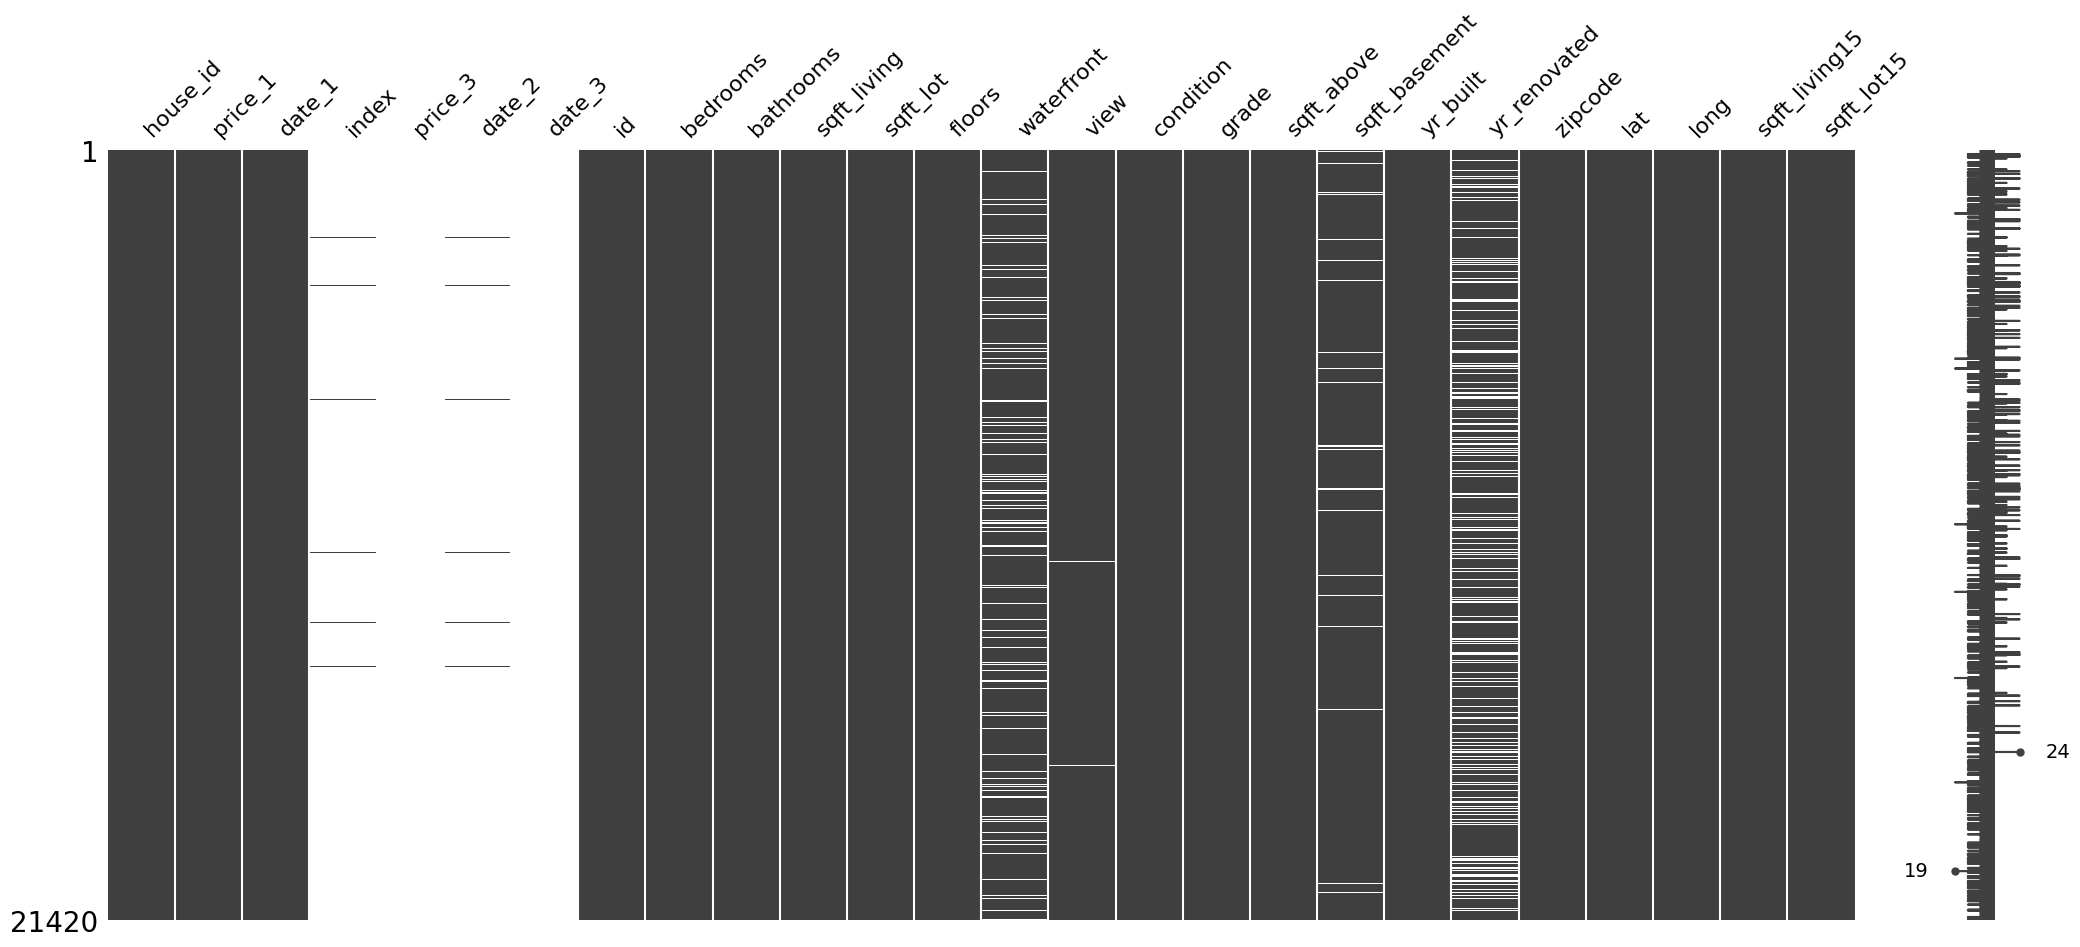

In [29]:
msno.matrix(df)

There seems to be no pattern. We store the dataframe in a new dataframe which we want to clear and use from now on. The split is done to keep original data accessable. 

In [30]:
df_clear = df

We now have to check whether it makes sense to produce syntetic data to fill in the gap or whether there are other ways to fill in the NaNs. 

__Column waterfront:__ It makes no sense to interpolate this value. Also, since our client specifically demands a waterfront, this would be very risky. Recommending a house with syntetic data here could lead to bad quality advise. It is recommended to assume that every house with NaN in waterfront has no waterfront. 

__Column view:__ It is unclear how this value was collected. It could be a subjective impression from the evaluators visit. It could be a criterea defined by the appearence of water and trees or the absense of nearby buildings or industry. In case of a subjective impression it is easier to argue that an interpolation makes sense. Also the amount of NaN is very limited which speaks in favor for an interpolation. Without any further information I would usually decide to set the value to 0 by default for every NaN. But since I want to practise this more, I decide to interpolate in this project. 

__Column sqft_basement:__ This value can be recalculated by the difference of sqrt_living and sqrt_above. 

__Column yr_renovated:__ An interpolation makes little sense here. Also the consequences of a wrong data entry are quite severe. We obstain from synthetic data and set all NaN to default 0. 

In [31]:
df_clear['waterfront'] = df_clear['waterfront'].where(df_clear['waterfront'].notna(), 0)
df_clear['view'] =  df_clear['view'].interpolate()
df_clear['sqft_basement'].fillna(df_clear['sqft_living'] - df_clear['sqft_above'], inplace=True)
df_clear['yr_renovated'] = df_clear['yr_renovated'].where(df_clear['yr_renovated'].notna(), 0)

Now we check whether all NaN are gone: 

In [32]:
error_waterfront_new = round(df_clear['waterfront'].isna().sum()/df_clear['waterfront'].shape[0]*100, 1)
error_view_new = round(df_clear['view'].isna().sum()/df_clear['view'].shape[0]*100, 1)
error_sqft_basement_new = round(df_clear['sqft_basement'].isna().sum()/df_clear['sqft_basement'].shape[0]*100, 1)
error_yr_renovated_new = round(df_clear['yr_renovated'].isna().sum()/df_clear['yr_renovated'].shape[0]*100, 1)
print(f"waterfront: {error_waterfront_new}%, view: {error_view_new}%, sqft_basement: {error_sqft_basement_new}%, yr_renovated: {error_yr_renovated_new}%")

waterfront: 0.0%, view: 0.0%, sqft_basement: 0.0%, yr_renovated: 0.0%


Let's not forget about the change of data type in column yr_renovated since all NaN are gone now. 

In [503]:
df_clear['yr_renovated'] = df_clear['yr_renovated'].astype(int)
df['yr_renovated'] = df['yr_renovated'] / 10
type(df_clear['yr_renovated'][13])

numpy.int32

Now we save the dataset and reload: 

In [504]:
df_clear.to_csv('data/data_clear.csv',index=False)
#df_clear = pd.read_csv('data/data_clear.csv')
df_clear[(df_clear['yr_renovated'] > 0)]



,house_id,price_1,date_1,index,price_3,date_2,date_3,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
12,5100401414,520000.000,2014-08-05,NaN,NaN,NaT,NaT,5100401414,2.000,1.000,880.000,6380.000,1.000,0.000,0.000,3,7,880.000,0.000,1938,1990,98115,47.692,-122.322,1340.000,6380.000,8
93,9828700200,255000.000,2014-05-07,NaN,NaN,NaT,NaT,9828700200,4.000,3.000,2170.000,4000.000,2.000,0.000,0.000,4,9,1610.000,560.000,1982,2010,98112,47.620,-122.292,1670.000,4000.000,5
125,325059171,889000.000,2015-04-14,NaN,NaN,NaT,NaT,325059171,3.000,1.000,1330.000,77972.000,1.000,0.000,0.000,3,7,1330.000,0.000,1928,1950,98033,47.689,-122.159,1340.000,17689.000,4
142,124069032,263000.000,2014-05-15,NaN,NaN,NaT,NaT,124069032,3.000,1.750,1670.000,39639.000,1.000,0.000,0.000,4,8,1670.000,0.000,1976,1990,98075,47.593,-121.989,2330.000,30492.000,5
177,871001980,146000.000,2015-02-09,NaN,NaN,NaT,NaT,871001980,3.000,3.500,3020.000,4082.000,2.000,0.000,0.000,3,9,2080.000,940.000,1954,2000,98199,47.651,-122.409,2060.000,5102.000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21220,7443000480,175000.000,2014-05-06,NaN,NaN,NaT,NaT,7443000480,4.000,2.000,2750.000,5527.000,2.000,0.000,0.000,3,8,2130.000,620.000,1901,1980,98119,47.651,-122.368,1290.000,1764.000,5
21224,3179100180,650000.000,2014-06-10,NaN,NaN,NaT,NaT,3179100180,5.000,3.250,2920.000,6960.000,2.000,0.000,1.000,3,9,2120.000,800.000,1953,2000,98105,47.671,-122.272,2470.000,6735.000,6
21254,1118000320,860000.000,2014-05-13,NaN,NaN,NaT,NaT,1118000320,4.000,4.000,4260.000,11765.000,2.000,0.000,0.000,3,11,3280.000,980.000,1939,2010,98112,47.638,-122.288,4260.000,10408.000,5
21371,3361400980,783500.000,2014-05-04,NaN,NaN,NaT,NaT,3361400980,2.000,1.000,600.000,6120.000,1.000,0.000,0.000,3,5,600.000,0.000,1943,1980,98168,47.500,-122.317,1090.000,6120.000,5


__Exploration__

We want to find out, where people invested money in improving their real estates. So we try to plot where renovations have happened: 

In [35]:
df_clear_renovated = df_clear[(df_clear['yr_renovated'] > 0)]
df_clear_renovated

,house_id,price_1,date_1,index,price_3,date_2,date_3,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12,5100401414,520000.000,2014-08-05,NaN,NaN,NaT,NaT,5100401414,2.000,1.000,880.000,6380.000,1.000,0.000,0.000,3,7,880.000,0.000,1938,19940,98115,47.692,-122.322,1340.000,6380.000
93,9828700200,255000.000,2014-05-07,NaN,NaN,NaT,NaT,9828700200,4.000,3.000,2170.000,4000.000,2.000,0.000,0.000,4,9,1610.000,560.000,1982,20110,98112,47.620,-122.292,1670.000,4000.000
125,325059171,889000.000,2015-04-14,NaN,NaN,NaT,NaT,325059171,3.000,1.000,1330.000,77972.000,1.000,0.000,0.000,3,7,1330.000,0.000,1928,19540,98033,47.689,-122.159,1340.000,17689.000
142,124069032,263000.000,2014-05-15,NaN,NaN,NaT,NaT,124069032,3.000,1.750,1670.000,39639.000,1.000,0.000,0.000,4,8,1670.000,0.000,1976,19920,98075,47.593,-121.989,2330.000,30492.000
177,871001980,146000.000,2015-02-09,NaN,NaN,NaT,NaT,871001980,3.000,3.500,3020.000,4082.000,2.000,0.000,0.000,3,9,2080.000,940.000,1954,20040,98199,47.651,-122.409,2060.000,5102.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21220,7443000480,175000.000,2014-05-06,NaN,NaN,NaT,NaT,7443000480,4.000,2.000,2750.000,5527.000,2.000,0.000,0.000,3,8,2130.000,620.000,1901,19870,98119,47.651,-122.368,1290.000,1764.000
21224,3179100180,650000.000,2014-06-10,NaN,NaN,NaT,NaT,3179100180,5.000,3.250,2920.000,6960.000,2.000,0.000,1.000,3,9,2120.000,800.000,1953,20080,98105,47.671,-122.272,2470.000,6735.000
21254,1118000320,860000.000,2014-05-13,NaN,NaN,NaT,NaT,1118000320,4.000,4.000,4260.000,11765.000,2.000,0.000,0.000,3,11,3280.000,980.000,1939,20100,98112,47.638,-122.288,4260.000,10408.000
21371,3361400980,783500.000,2014-05-04,NaN,NaN,NaT,NaT,3361400980,2.000,1.000,600.000,6120.000,1.000,0.000,0.000,3,5,600.000,0.000,1943,19890,98168,47.500,-122.317,1090.000,6120.000


Since we start now with the plotting, let's define a color scheme first, so everything looks nice and fits our corporate design. 

In [436]:
color_first = '#0366C9'
color_second = '#EC9A29'
color_alert = '#FF4365'
color_neutral = '#404E4D'


In [476]:
import plotly.express as px

fig = px.scatter_mapbox(df_clear, lat="lat", lon="long", 
                        color_discrete_sequence=["#0366C9"], zoom=10)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=1200, height=800)

fig.update_layout(title="Most renovations take place at the urban center", title_x=0.5) 

fig.show()

In [477]:
fig = px.scatter_mapbox(df_clear_renovated, lat="lat", lon="long", 
                        color_discrete_sequence=["#0366C9"], zoom=10)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=1200, height=800)

fig.update_layout(title="Most renovations take place at the urban center", title_x=0.5) 

fig.show()


As it turns out, there is a lot of money flowing into improving houses in the larger area of Seattle and southern districts. Elsewhere, there is little improvement. 

We remember that there were houses with NaN in column waterfront. We want to find those and check whether it is worth visiting them again to check whether there is really no waterfront as we have filled in the gaps. 

In [478]:
df_clear_waterfrontnan = df_details[(df_details['waterfront'].isna())]
import plotly.express as px

fig = px.scatter_mapbox(df_clear_waterfrontnan, lat="lat", lon="long", 
                        color_discrete_sequence=["#0366C9"], zoom=10)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(width=1200, height=800)

fig.update_layout(title="Which houses with missing waterfront data can be excluded?", title_x=0.5) 


fig.show()

We could now combine this with a [dataset that holds information](https://geo.wa.gov/datasets/57a2cf1fbc5e434f9113b5cb9dbfb0d6_15/explore?location=47.521910%2C-122.168264%2C11.59) about the areas of waterbodies and then run a query to exclude all houses that are more far away than, let's say 500 meter from a waterbody. Sadly, out imperfect coding skills and the lack of time (tried it for three hours) made this impossible. So, we move on. 

Since it is already a bit late and we run out of serious ideas we now want to know whether we can still see the Great Depression in the data. Since we later not only want to check how many houses are available from that period but also show how their prices are, we exclude all houses that have been renovated and who's prices therefore have been 'resetted'. 

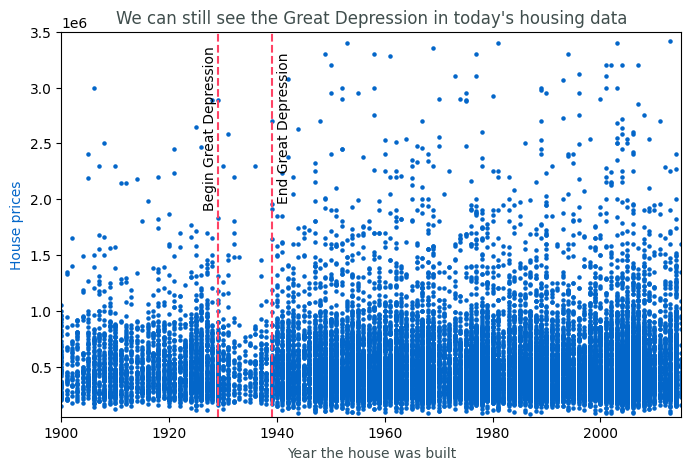

In [462]:
import matplotlib.pyplot as plt

df_greatdepression = df[df['yr_renovated'] == 0]

plt.scatter(df_greatdepression['yr_built'], df_greatdepression['price_1'], s=5, color="#0366C9")

plt.title("We can still see the Great Depression in today's housing data", color='#404E4D')
plt.xlabel('Year the house was built', color='#404E4D')
plt.ylabel('House prices', color="#0366C9")

plt.ylim(50000, 3500000)
plt.xlim(1900, 2015)
plt.axvline(x=1929, color='#FF4365', linewidth=1.5, linestyle='--')
plt.axvline(x=1939, color='#FF4365', linewidth=1.5, linestyle='--')
plt.text(.24, 0.75, 'Begin Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes)
plt.text(.36, 0.75, 'End Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes)


plt.show()


As it turns out, it seems that there are way less real estates for offer compared to the earlier or the later decade. But let's check that out accordingly: 

Let's plot that because I think we can get some valuable insides here. 

In [39]:
df_greatdepression['decade'] = ((df_greatdepression['yr_built'] // 10)) * 10
decade_counts = df_greatdepression.groupby('decade').size()

print(decade_counts)

decade
1900     568
1910     698
1920    1079
1930     451
1940    1615
1950    2288
1960    2548
1970    2227
1980    2247
1990    2216
2000    3505
2010    1238
dtype: int64


In [40]:
decade_medians = df_greatdepression.groupby('decade')['price_1'].mean()

print(decade_medians)


decade
1900   567111.352
1910   538527.484
1920   533895.819
1930   521054.922
1940   544860.768
1950   530917.018
1960   543841.432
1970   533499.339
1980   543510.563
1990   542605.139
2000   544564.001
2010   526737.205
Name: price_1, dtype: float64


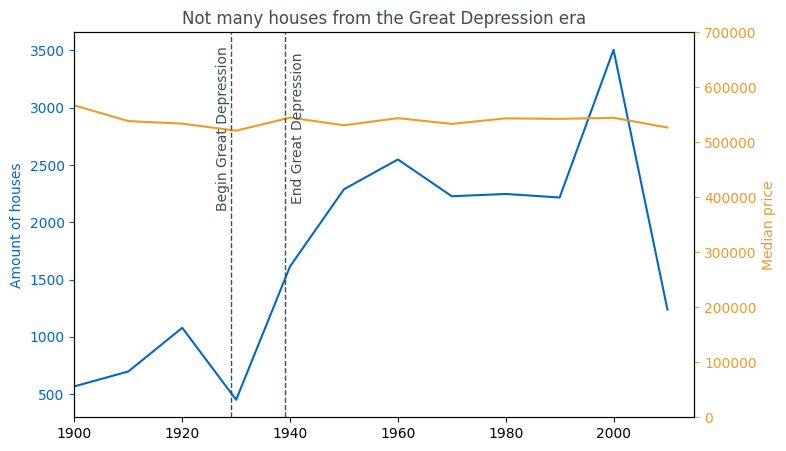

In [463]:
fig, ax1 = plt.subplots()

ax1.plot(decade_counts.index, decade_counts.values, label='Decade Counts', color='#0366C9')
ax1.set_ylabel('Amount of houses', color='#0366C9')
ax1.tick_params('y', colors='#0366C9')

ax2 = ax1.twinx()

ax2.plot(decade_medians.index, decade_medians.values, label='Decade Medians', color='#EC9A29')
ax2.set_ylabel('Median price', color='#EC9A29')
ax2.tick_params('y', colors='#EC9A29')

ax1.set_title('Not many houses from the Great Depression era', color='#404E4D')

plt.xlim(1900, 2015)
plt.ylim(0, 700000)

plt.axvline(x=1929, color='#404E4D', linewidth=1, linestyle='--')
plt.axvline(x=1939, color='#404E4D', linewidth=1, linestyle='--')
plt.text(.24, 0.75, 'Begin Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')
plt.text(.36, 0.75, 'End Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')

plt.show()

So, what do we see here? Assuming that the current available houses correlate with the houses built during that episode we can see, that people have built less houses during the crisis. As expected. The crisis hit hard, but afterwards people needed homes. So the numbers rose again very fast. 

So, people had less money and stoped building homes. Did the homes themselves change?

In [42]:
decade_lots = df_greatdepression.groupby('yr_built')['sqft_lot'].median()
decade_floors = df_greatdepression.groupby('yr_built')['floors'].mean()
decade_floors

yr_built
1900   1.479
1901   1.554
1902   1.731
1903   1.440
1904   1.346
        ... 
2011   2.015
2012   1.994
2013   2.043
2014   2.126
2015   2.224
Name: floors, Length: 116, dtype: float64

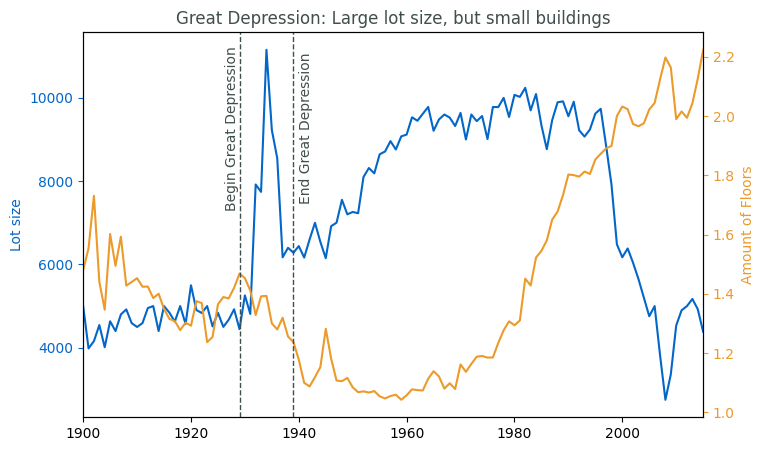

In [464]:
fig, ax1 = plt.subplots()

ax1.plot(decade_lots.index, decade_lots.values, label='Lots', color='#0366C9')
ax1.set_ylabel('Lot size', color='#0366C9')
ax1.tick_params('y', colors='#0366C9')

ax2 = ax1.twinx()

ax2.plot(decade_floors.index, decade_floors.values, label='Floors', color='#EC9A29')
ax2.set_ylabel('Amount of Floors', color='#EC9A29')
ax2.tick_params('y', colors='#EC9A29')

ax1.set_title('Great Depression: Large lot size, but small buildings', color='#404E4D')

plt.xlim(1900, 2015)

plt.axvline(x=1929, color='#404E4D', linewidth=1, linestyle='--')
plt.axvline(x=1939, color='#404E4D', linewidth=1, linestyle='--')
plt.text(.24, 0.75, 'Begin Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')
plt.text(.36, 0.75, 'End Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')

plt.show()

As we can see people really tend to built smaller houses during and after the crisis. Money war rar, so investors very likely cut their investments and planed for smaller builings. This kept on going after the crisis for many decades. 

For the lots we see a different development: Many people were forced to sell land to get money, so land prices fell as a result. During the crisis years this peaked very steep. Crazy! But this is another analysis for another day. Let's keep on with the building material check. 

So, did they also reduce the quality of their material?

In [44]:
decade_grades_mean = df_greatdepression.groupby('yr_built')['grade'].mean()
decade_grades_mean

yr_built
1900   6.795
1901   7.000
1902   7.423
1903   6.786
1904   6.846
        ... 
2011   8.185
2012   8.178
2013   8.467
2014   8.560
2015   8.921
Name: grade, Length: 116, dtype: float64

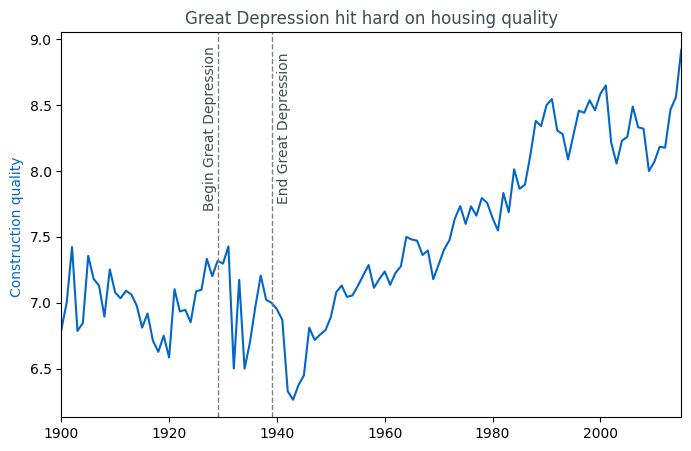

In [467]:
fig, ax1 = plt.subplots()

ax1.plot(decade_grades_mean.index, decade_grades_mean.values, label='quality', color='#0366C9')
ax1.set_ylabel('Construction quality ', color='#0366C9')

ax1.set_title('Great Depression hit hard on housing quality', color='#404E4D')

plt.xlim(1900, 2015)

plt.axvline(x=1929, color='gray', linewidth=1, linestyle='--')
plt.axvline(x=1939, color='gray', linewidth=1, linestyle='--')
plt.text(.24, 0.75, 'Begin Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')
plt.text(.36, 0.75, 'End Great Depression', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')

plt.show()

We were right. Our little history excurse has taught us a lot which we can also use for our business advises: Quality strongly decrease during the crisis. __And also fell after the Great Depression ended.__ So, this is a red flag. We should double-check houses from this time on quality, otherwise, this might be money down the drain. 

We have got a call from Jennifer Montgomery, a woman a bit tiring from lower high class. She wants to buy a real estate and resell it within a year. So, it is less for her own purpose but for making money. Lovely. So here are her demands: She wants to show off, a waterfront and the house should be renovated. It should have high grades in material and the timing should be within a month. 
* high budget
* wants to show off
* timing within a month
* waterfront
* renovated
* high grades
* resell within 1 year

So, how do we put these demands into numbers. As said, Lady Montgomery is lower high class. She wants to show off, but she is not Mrs. Bezos. So, we put her in the upper 20% of the overall population. 
Or, in numbers, she wants to buy higher than the 80th percentile. This means that price and building material should be higher than 80% of the offered real estates. 

Additionally, she wants to feel special and above average. So her house must have 10% more interior housing living space and 10% more land lots than the average of her neighbours. 
Also, of course, there must be a waterfront and a renovation. But since a renovation more than fifty years ago is worth nothing, we put in a treshold of 50 years here. An earlier renovation doesn't count. 
Since she wants to sell the real estate soon again, she might need good arguments for the next owners. A good view is always a nice thing to have and people pay a lot for it. So, we want a view rating that is equal or better than 95% of all other houses. 




In [513]:
from datetime import datetime

treshold = 0.8
treshold_year = 50
treshold_view = 0.95

price_montgomery = df_clear['price_1'].quantile(treshold)
sqft_living15_montgomery = df_clear['sqft_living15'] * 1.1 
sqft_lot15_montgomery = df_clear['sqft_lot15'] * 1.1 
grade_montgomery = df_clear['grade'].quantile(treshold)
view_montgomery = df_clear['view'].quantile(treshold_view)

df_montgomery = df_clear[
    (df_clear['price_1'] > price_montgomery) &
    (df_clear['sqft_living'] > sqft_living15_montgomery) &
    (df_clear['sqft_lot'] > sqft_lot15_montgomery) &
    (df_clear['waterfront'] == 1) &
    (df_clear['yr_renovated'] > (datetime.now().year - treshold_year)) &
    (df_clear['grade'] > grade_montgomery) &
    (df_clear['view'] >= view_montgomery) 
    ]

df_montgomery.head()

,house_id,price_1,date_1,index,price_3,date_2,date_3,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
2444,9808700762,749950.000,2014-06-05,<NA>,<NA>,NaT,NaT,9808700762,5.000,4.500,10040.000,37325.000,2.000,1.000,2.000,3,11,7680.000,2360.000,1940,2000,98004,47.650,-122.214,3930.000,25449.000,6
2814,1924059029,775000.000,2014-05-07,<NA>,<NA>,NaT,NaT,1924059029,5.000,6.750,9640.000,13068.000,1.000,1.000,4.000,3,12,4820.000,4820.000,1983,2000,98040,47.557,-122.210,3270.000,10454.000,5
14519,3625059152,1490000.000,2015-01-29,<NA>,<NA>,NaT,NaT,3625059152,3.000,3.250,4220.000,41300.000,1.000,1.000,4.000,4,11,2460.000,1760.000,1958,1980,98008,47.608,-122.110,3810.000,30401.000,1


In [487]:
(datetime.now().year - treshold_year)

1999

And there we are. Three recommandations to check out.

Since our customer Mrs. Montgomery also wants to buy within a month and sell within a year, we should also analyse the price development over time to give her some advise. 

In [480]:
df_clear['month'] = pd.to_datetime(df['date_1']).dt.month
df_clear['month'] = df_clear['month'].astype(int)
df_clear.tail()

,house_id,price_1,date_1,index,price_3,date_2,date_3,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
21415,8149600265,365000.000,2014-07-25,<NA>,<NA>,NaT,NaT,8149600265,4.000,1.750,1980.000,5850.000,1.000,0.000,1.000,4,8,1380.000,600.000,1960,0,98116,47.561,-122.391,1810.000,5850.000,7
21416,4166600610,380000.000,2015-03-11,<NA>,<NA>,NaT,NaT,4166600610,3.000,2.000,1410.000,44866.000,1.000,0.000,0.000,4,7,1410.000,0.000,1985,0,98023,47.327,-122.370,2950.000,29152.000,3
21417,7923600250,339000.000,2014-06-24,<NA>,<NA>,NaT,NaT,7923600250,5.000,2.000,1870.000,7344.000,1.500,0.000,0.000,3,7,1870.000,0.000,1960,0,98007,47.595,-122.144,1870.000,7650.000,6
21418,5101400871,399900.000,2014-07-03,<NA>,<NA>,NaT,NaT,5101400871,2.000,1.750,1390.000,6670.000,1.000,0.000,0.000,3,6,720.000,670.000,1941,0,98115,47.691,-122.308,920.000,6380.000,7
21419,9106000005,268950.000,2014-10-30,<NA>,<NA>,NaT,NaT,9106000005,4.000,2.250,3750.000,5000.000,2.000,0.000,0.000,5,8,2440.000,1310.000,1924,0,98115,47.675,-122.303,2170.000,4590.000,10


In [335]:
df_timing = df_clear.groupby('month')['price_1'].median().reset_index()
df_timing.rename(columns={'price_1': 'median'}, inplace=True)

current_month = datetime.now().month
current_month = df_timing.loc[current_month - 1, 'median'] 

df_timing['change'] = round((df_timing['median'] / current_month) * 100 - 100, 3)

print(df_timing.head(12))



    month     median  change
0       1 438500.000  -5.699
1       2 425545.000  -8.485
2       3 450000.000  -3.226
3       4 479000.000   3.011
4       5 462500.000  -0.538
5       6 465000.000   0.000
6       7 465000.000   0.000
7       8 442000.000  -4.946
8       9 450000.000  -3.226
9      10 447000.000  -3.871
10     11 435000.000  -6.452
11     12 432500.000  -6.989


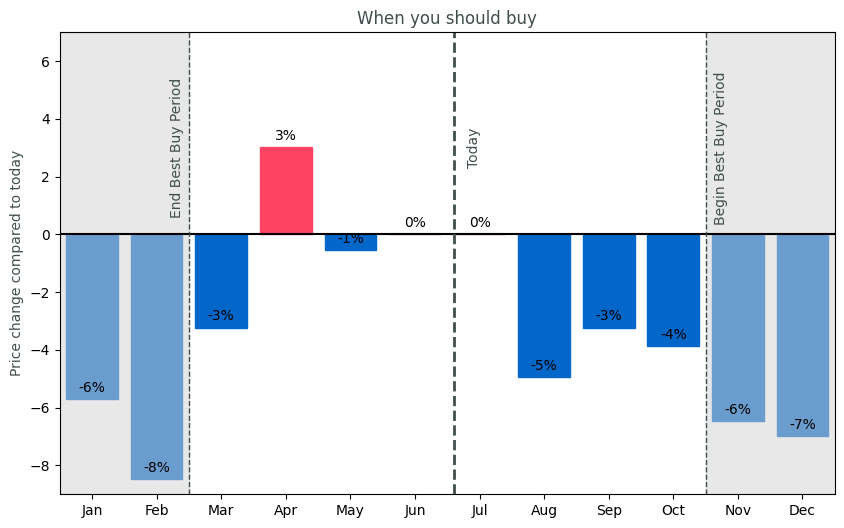

In [472]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
current_month = datetime.now().month - 1 + datetime.now().day / 30

plt.figure(figsize=(10, 6))
ax = plt.gca()

bar_positions = range(len(df_timing))
bar_heights = df_timing['change']
bars = ax.bar(bar_positions, bar_heights, align='center')

for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.0f}%'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for container in ax.containers:
    for bar in container:
        if bar.get_height() < 0:  # Assuming negative values are less than 100
            bar.set_color('#0366C9')
        else:
            bar.set_color('#FF4365')  # Set the default color to blue for positive values

plt.ylabel('Price change compared to today', color='#404E4D')
plt.title('When you should buy', color='#404E4D')

plt.ylim(-9, 7)
plt.xlim(-0.5, len(bar_positions) - 0.5)  

plt.xticks(bar_positions, month_names)

plt.axhline(y=0, color='black', linestyle='-')

plt.axvspan(-0.5, 1.5, alpha=0.5, color='lightgray')
plt.axvspan(9.5, 11.5, alpha=0.5, color='lightgray')

plt.axvline(x=9.5, color='#404E4D', linewidth=1, linestyle='--')
plt.text(10/12 + 0.02, 0.75, 'Begin Best Buy Period', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')
plt.axvline(x=1.5, color='#404E4D', linewidth=1, linestyle='--')
plt.text(2/12 - 0.015, 0.75, 'End Best Buy Period', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')
plt.axvline(x=current_month, color='#404E4D', linewidth=2, linestyle='--')
plt.text(current_month / 12 + 1/12 - 0.015, 0.75, 'Today', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')

plt.show()

Well, speaking of buying we are currently not in the best month. There is only one month worth than June: April, where prices are even 3% higher than today. From August on prices usually are lower and hit their minimum around February. So, we will advise Mrs. Montgomery to wait half a year if she wants to have the best deal.

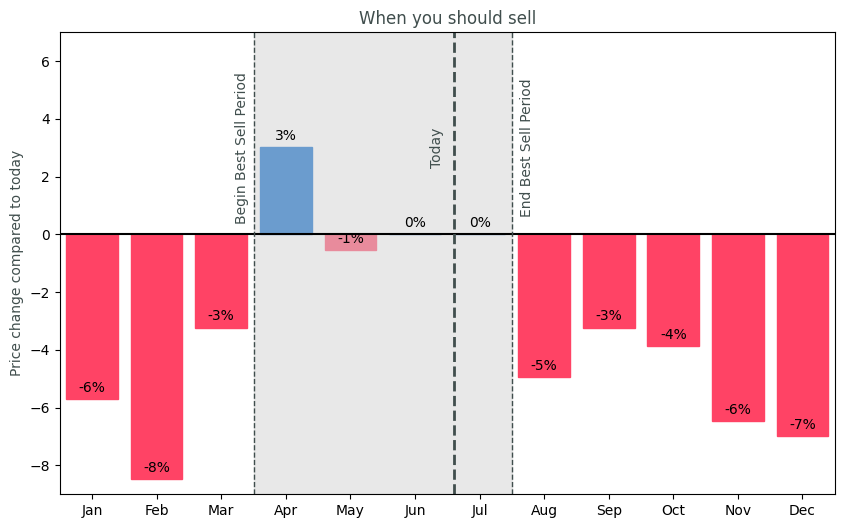

In [474]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
current_month = datetime.now().month - 1 + datetime.now().day / 30

plt.figure(figsize=(10, 6))
ax = plt.gca()

bar_positions = range(len(df_timing))
bar_heights = df_timing['change']
bars = ax.bar(bar_positions, bar_heights, align='center')

for bar in bars:
    height = bar.get_height()
    ax.annotate('{:.0f}%'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

for container in ax.containers:
    for bar in container:
        if bar.get_height() < 0:  # Assuming negative values are less than 100
            bar.set_color('#FF4365')
        else:
            bar.set_color('#0366C9')  # Set the default color to blue for positive values

plt.ylabel('Price change compared to today', color='#404E4D')
plt.title('When you should sell', color='#404E4D')

plt.ylim(-9, 7)
plt.xlim(-0.5, len(bar_positions) - 0.5)  

plt.xticks(bar_positions, month_names)

plt.axhline(y=0, color='black', linestyle='-')

plt.axvspan(2.5, 6.5, alpha=0.5, color='lightgray')

plt.axvline(x=2.5, color='#404E4D', linewidth=1, linestyle='--')
plt.text(3/12 - 0.015, 0.75, 'Begin Best Sell Period', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')
plt.axvline(x=6.5, color='#404E4D', linewidth=1, linestyle='--')
plt.text(7/12 + 0.02, 0.75, 'End Best Sell Period', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')
plt.axvline(x=current_month, color='#404E4D', linewidth=2, linestyle='--')
plt.text(current_month / 12 - 0/12 + 0.02, 0.75, 'Today', rotation=90, ha='center', va='center', transform=plt.gca().transAxes, color='#404E4D')

plt.show()

The best month to sell again would be April, then. Maybe because people like lots where flowers are blossoming. So, they might to influenced to pay higher prices. A little hint could be to invest some houndred dollars in a gardener who could level up the real estate quite a bit for little money. 